### 37. 텐서를 다루다

#### 1) 원소별 계산

In [1]:
import numpy as np
import dezero.functions as F
from dezero import Variable
from dezero import Function
from dezero import utils

In [7]:
x = Variable(np.array(1.0))
y = F.sin(x)
print(y)

variable(0.8414709848078965)


In [8]:
# x가 텐서인 경우, sin함수가 원소별로 적용됨 (broadcast)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sin(x)
print(y)

variable([[ 0.84147098  0.90929743  0.14112001]
          [-0.7568025  -0.95892427 -0.2794155 ]])


#### 2) 텐서 사용시의 역전파
- 그동안 '스칼라'를 대상으로 역전파를 구현함. 브로드캐스팅에 의해 역전파는 '텐서'의 원소별 계산에서도 성립

<img src='img/37_1.png' width='400'>

In [9]:
# 확인

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
c = Variable(np.array([[10, 20, 30], [40, 50, 60]]))
t = x + c
y = F.sum(t)

In [10]:
y.backward(retain_grad=True)
print(y.grad)
print(t.grad)
print(x.grad)
print(c.grad)

variable(1)
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])
variable([[1 1 1]
          [1 1 1]])


현재, 기울기의 형상과 데이터의 형상이 일치 (즉, x.shape == x.grad.shape)  
-> sum이나 reshape 함수 등을 구현하기 어렵지 않음

#### 3) [보충] 텐서 사용 시의 역전파
합성 함수 __$y$__ = $F($__$y$__$)$, __$a$__ = $A($__$x$__$)$, __$b$__ = $B($__$a$__$)$, __$y$__ = $C($__$b$__$)$에서 y의 __$x$__에 대한 미분은 아래와 같다. 계산순서 forward 모드와 reverse 모드를 살펴보자.
<img src='img/37_2.png' width='100'>
 
- forward 모드
<img src='img/37_3.png' width='300'>

- reverse 모드
<img src='img/37_4.png' width='280'>


- 이때, reverse 모드는 1\*n 벡터를 전파하지만, forward 모드에서는 n\*n을 전파한다. 계산량이 적으므로 계산 효율이 좋다.
- 또한, 야코비안 행렬을 구하여 '행렬의 곱'을 계산할 필요가 없다. $\partial a/\partial x$이 대각행렬이기 때문에 원소별로 곱하면 된다.
<img src='img/37_5.png' width='120'>

### 38. 형상 변환 함수
- 원소별 연산을 수행하는 함수(add, sin 등)는 텐서여도 잘 계산할 수 있지만,  
reshape과 transpose 함수처럼 텐서의 형상을 변환하는 함수들은 다시 구현을 해주어야 한다

#### 1) reshape 함수 구현
<img src='img/37_6.png' width='250'>

In [1]:
import numpy as np

x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.reshape(x, (6, ))
print(y)

[1 2 3 4 5 6]


In [22]:
######################################################## dezero/functions.py

class Reshape(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape   # reshape 하기 전의 shape
        y = x.reshape(self.shape)
        return y
    
    def backward(self, gy):
        return reshape(gy, self.x_shape)  # reshape 하기 전의 shape로 돌려주기

In [23]:
from dezero.core import as_variable

def reshape(x, shape):
    if x.shape == shape:  # reshape하려는 shape과 현재의 shape이 같으면
        return as_variable(x)  # 그대로 돌려주기
    return Reshape(shape)(x)

In [24]:
# 구현한 reshape 함수 사용하기

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.reshape(x, (6, ))
y.backward(retain_grad=True)
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


#### 2) Variable에서 reshape 사용하기

In [26]:
x = np.random.rand(1, 2, 3)

y = x.reshape((2, 3))
y = x.reshape([2, 3])
y = x.reshape(2, 3)

In [25]:
#################################################### dezero/core.py의 Variable

def reshape(self, *shape):
    if len(shape) == 1 and isinstance(shape[0], (tuple, list)):
        shape = shape[0]
    
    return dezero.functions.reshape(self, shape)

In [27]:
x = Variable(np.random.randn(1, 2, 3))
y = x.reshape((2, 3))
y = x.reshape(2, 3)

#### 3) 행렬의 전치

In [29]:
# 넘파이에서의 transpose

x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.transpose(x)
print(y)

[[1 4]
 [2 5]
 [3 6]]


In [30]:
######################################################## dezero/functions.py

class Transpose(Function):
    def forward(self, x):
        y = np.transpose(x)
        return y
    
    def backward(self, gy):
        gx = transpose(gy)
        return gx
    
def transpose(x):
    return Transpose()(x)

In [31]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.transpose(x)
y.backward()
print(x.grad)

variable([[1 1 1]
          [1 1 1]])


In [32]:
######################################################## dezero/core.py

def transpose(self):
    return dezero.functions.transpose(self)

@property
def T(self):
    return dezero.functions.transpose(self)

In [33]:
x = Variable(np.random.rand(2, 3))
y = x.transpose()
y = x.T

#### 4) 실제 transpose 함수
- 넘파이의 np.transpose 함수는 더 범용적으로 사용가능

In [37]:
# 축의 데이터 순서 바꿀 수 있음

A, B, C, D = 1, 2, 3, 4
x = np.random.rand(A, B, C, D)
x

array([[[[0.59011832, 0.0598224 , 0.18197858, 0.84619198],
         [0.03845406, 0.80756561, 0.21671976, 0.80517591],
         [0.52603176, 0.62795826, 0.76339484, 0.06938922]],

        [[0.96843249, 0.20920264, 0.87448685, 0.61155848],
         [0.67926472, 0.21911552, 0.00572954, 0.71833413],
         [0.31517635, 0.17452025, 0.15189772, 0.03867657]]]])

In [38]:
y = x.transpose(1, 0, 3, 2)  # 인수에 아무것도 넣지 않으면 역순으로 정렬됨
y                            # 0번째와 1번째 축의 데이터 -> 1번째와 0번째 순서

array([[[[0.59011832, 0.03845406, 0.52603176],
         [0.0598224 , 0.80756561, 0.62795826],
         [0.18197858, 0.21671976, 0.76339484],
         [0.84619198, 0.80517591, 0.06938922]]],


       [[[0.96843249, 0.67926472, 0.31517635],
         [0.20920264, 0.21911552, 0.17452025],
         [0.87448685, 0.00572954, 0.15189772],
         [0.61155848, 0.71833413, 0.03867657]]]])

In [35]:
x.shape

(1, 2, 3, 4)

In [36]:
y.shape

(2, 1, 4, 3)

### 39. 합계 함수

#### 1) sum 함수의 역전파
<img src='img/39_1.png' width='300'>

- $y=x_0+x_1$일 때, $\partial y/\partial x_0 = 1, \partial y/\partial x_1 = 1$이므로 출력 쪽에서 기울기를 두 개로 '복사'하여 전달하면 됨! 
- 만약 원소가 2개 이상이거나 2차원 이상의 배열이면 원소 수만큼 '복사'하면 됨

#### 2) sum 함수 구현

In [3]:
######################################################## dezero/functions.py
# 뒤에서 구현할 broadcast_to 함수 이용하기

class Sum(Function):
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum()
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx

def sum(x):
    return Sum()(x)

In [4]:
x = Variable(np.array([1, 2, 3, 4, 5, 6]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([1 1 1 1 1 1])


In [6]:
# 2차원 배열인 경우

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x)
y.backward()
print(y)
print(x.grad)

variable(21)
variable([[1 1 1]
          [1 1 1]])


#### 3) sum 함수 확장하기 : axis와 keepdims

<img src='img/39_2.png' width='200'>

In [7]:
# 넘파이 np.sum 함수의 기능 (axis)

x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, axis=0)
print(y)
print(x.shape, '->', y.shape)

[5 7 9]
(2, 3) -> (3,)


In [8]:
# 넘파이 np.sum 함수의 기능 (keepdims)

x = np.array([[1, 2, 3], [4, 5, 6]])
y = np.sum(x, keepdims=True)
print(y)
print(y.shape)  # 축이 유지됨

[[21]]
(1, 1)


In [10]:
######################################################## dezero/functions.py
# sum 함수 구현하기

class Sum(Function):
    def __init__(self, axis, keepdims):
        self.axis = axis
        self.keepdims = keepdims
        
    def forward(self, x):
        self.x_shape = x.shape
        y = x.sum(axis=self.axis, keepdims=self.keepdims)
        return y
    
    def backward(self, gy):
        gy = utils.reshape_sum_backward(gy, self.x_shape, self.axis,
                                       self.keepdims)
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum(x, axis=None, keepdims=False):
    return Sum(axis, keepdims)(x)

In [ ]:
################################################################ dezero/core.py
class Variable:
    # ...
    
    def sum(self, axis=None, keepdims=False):
        return dezero.functions.sum(self, axis, keepdims)

In [11]:
# 사용하기

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()
print(y)
print(x.grad)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])


In [12]:
x = Variable(np.random.randn(2, 3, 4, 5))
y = x.sum(keepdims=True)
print(y.shape)

(1, 1, 1, 1)


### 40. 브로드캐스트 함수

#### 1) broadcast_to 함수와 sum_to 함수 (넘파이 버전)
- broadcast_to(x, shape) : ndarray 인스턴스인 x의 원소를 복제하여 shape 인수로 지정한 형상이 되도록 하는 함수
- 역전파 시에는 아래와 같이 동작함 (두번 사용되니까 기울기를 합해줌)

<img src='img/40_1.png' width='300'>

In [2]:
x = np.array([1, 2, 3])
y = np.broadcast_to(x, (2, 3))
print(y)

[[1 2 3]
 [1 2 3]]


In [3]:
from dezero.utils import sum_to

In [8]:
# sum_to : x의 원소의 합을 구해 shape 형상으로 만들어주는 함수
# 넘파이에 이런 함수가 없으므로 dezero/utils.py에 넘파이 버전 sum_to 함수를 넣어둠

x = np.array([[1, 2, 3], [4, 5, 6]])
y = sum_to(x, (1, 3))
print(y)

[[5 7 9]]


In [7]:
y = sum_to(x, (2, 1))
print(y)

[[ 6]
 [15]]


<img src='img/40_2.png' width='300'>

#### 2) broadcast_to 함수와 sum_to 함수 (DeZero 버전)

In [ ]:
### dezero/functions.py
# BroadcastTo 클래스와 broadcast_to 함수

class BroadcastTo(Function):
    def __init__(self, shape):
        self.shape = shape
        
    def forward(self, x):
        self.x_shape = x.shape
        y = np.broadcast_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = sum_to(gy, self.x_shape)
    
def broadcast_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return BroadcastTo(shape)(x)

In [ ]:
### dezero/functions.py
# SumTo 클래스와 sum_to 함수

from dezero import utils

class SumTo(Function):
    def __init__(self, shape):
        self.shape = shape
    
    def forward(self, x):
        self.x_shape = x.shape
        y = utils.sum_to(x, self.shape)
        return y
    
    def backward(self, gy):
        gx = broadcast_to(gy, self.x_shape)
        return gx
    
def sum_to(x, shape):
    if x.shape == shape:
        return as_variable(x)
    return SumTo(shape)(x)

#### 3) 브로드캐스트 대응
- 순전파는 ndarray를 사용해 구현했기 때문에 브로드캐스트가 일어나지만,   
'브로드캐스트의 역전파'가 일어나지 않음

In [10]:
x0 = np.array([1, 2, 3])
x1 = np.array([10])
y = x0 + x1
print(y)

[11 12 13]


In [11]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [ ]:
### dezero/core.py

class Add(Function):
    def forward(self, x0, x1):
        self.x0_shape, self.x1_shape = x0.shape, x1.shape
        y = x0 + x1
        return y
    
    def backward(self, gy):
        if self.x0_shape != self.x1_shape:
            gx0 = dezero.functions.sum_to(gx0, self.x0_shape)
            gx1 = dezero.functions.sum_to(gx1, self.x1_shape)
        return gx0, gx1

In [12]:
from dezero import Variable

In [13]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))
y = x0 + x1
print(y)

variable([11 12 13])


In [14]:
y.backward()
print(x1.grad)

variable([3])


### 41. 행렬의 곱

#### 1) 벡터의 내적과 행렬의 곱

In [15]:
# 벡터의 내적

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.dot(a, b)
print(c)

32


In [16]:
# 행렬의 곱

a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print(c)

[[19 22]
 [43 50]]


- 역전파
<img src='img/41_1.png' width='120'>
<img src='img/41_2.png' width='200'>
<img src='img/41_3.png' width='100'>
<img src='img/41_4.png' width='500'>  





- 형상 확인

<img src='img/41_5.png' width='200'>

In [17]:
### dezero/functions.py

class MatMul(Function):
    def forward(self, x, W):
        y = x.dot(W)
        return y
    
    def backward(self, gy):
        x, W = self.inputs
        gx = matmul(gy, W.T)
        gW = matmul(x.T, gy)
        return gx, gW
    
def matmul(x, W):
    return MatMul(x, W)

In [19]:
x = Variable(np.random.randn(2, 3))
W = Variable(np.random.rand(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


### 42. 선형 회귀

#### 1) 토이 데이터셋

In [21]:
np.random.seed(0)  # 시드값 고정
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

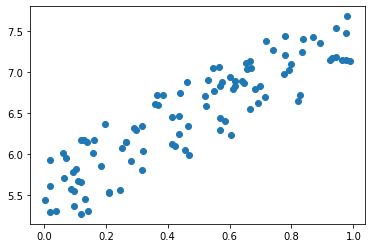

In [24]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'o')

#### 2) 선형 회귀 이론
- 평균 제곱 오차의 최소화
<img src='img/42_6.png' width='150'>

#### 3) 선형 회귀 구현

In [2]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [3]:
# 토이 데이터셋
np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)
x, y = Variable(x), Variable(y)  # 생략 가능

In [4]:
W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

In [5]:
def predict(x):
    y = F.matmul(x, W) + b
    return y

<img src='img/42_7.png' width='250'>

                        x.shape[1]와 W.shape[0]을 일치시켜야 함

In [6]:
# 후반 코드

def mean_squared_error(x0, x1):
    diff = x0 - x1
    return F.sum(diff ** 2) / len(diff)

In [7]:
lr = 0.1
iters = 100

for i in range(iters):
    y_pred = predict(x)
    loss = mean_squared_error(y, y_pred)
    
    W.cleargrad()
    b.cleargrad()
    loss.backward()
    
    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data
    print(W, b, loss)

variable([[0.64433458]]) variable([1.29473389]) variable(42.296340129442335)
variable([[1.12672345]]) variable([2.26959351]) variable(23.97380754378544)
variable([[1.48734571]]) variable([3.00386712]) variable(13.609686745040522)
variable([[1.75641886]]) variable([3.557186]) variable(7.747049961219976)
variable([[1.95666851]]) variable([3.97439789]) variable(4.43057410592155)
variable([[2.10518573]]) variable([4.28923203]) variable(2.5542803813535926)
variable([[2.21482401]]) variable([4.52705574]) variable(1.4925998690471942)
variable([[2.29524981]]) variable([4.70694745]) variable(0.8916952181756932)
variable([[2.35373273]]) variable([4.84325585]) variable(0.5514270962227453)
variable([[2.39573972]]) variable([4.9467725]) variable(0.35859153083192785)
variable([[2.425382]]) variable([5.02561369]) variable(0.2491573197756112)
variable([[2.44575118]]) variable([5.08588371]) variable(0.18690658765397886)
variable([[2.45917205]]) variable([5.13217364]) variable(0.15135336296314875)
varia

#### 보충) DeZero의 mean_squared_error
- 위의 mean_squared_error 함수를 이용할 경우, 아래와 같이 이름이 없는 변수 세개에 대한 메모리가 계속 살아있음 => 이를 해결하자!

<img src='img/42_8.png' width='400'>

In [ ]:
### dezero/functions.py

class MeanSquaredError(Function):
    def forward(self, x0, x1):
        diff = x0 - x1
        y = (diff ** 2).sum() / len(diff)
        return y
    
    def backward(self, gy):
        x0, x1 = self.inputs
        diff = x0 - x1
        gx0 = gy * diff * (2. / len(diff))
        gx1 = -gx0
        return gx0, gx1
    
def mean_squared_error(x0, x1):
    return MeanSquaredError(x0, x1)

<img src='img/42_9.png' width='250'>

### 43. 신경망

#### 1) Dezero의 linear 함수
"y = F.matmul(x, W) + b"를 통해 affine 변환을 하였는데, 아래에서 볼 수 있듯이 t의 메모리가 필요없음 => t의 데이터를 삭제해주자!  
<img src='img/43_1.png' width='200'>

In [ ]:
### dezero/functions.py

def linear_simple(x, W, b=None):
    t = matmul(x, W)
    if b is None:
        return t
    
    y = t + b
    t.data = None
    return y

    - 신경망에서 메모리의 대부분을 차지하는 것이 중간 계산 결과인 텐서(ndarray 인스턴스) 
    => 불필요한 인스턴스를 즉시 삭제하는 것이 바람직! (Aggresive Buffer Release라는 방법을 통해 자동화도 할 수 있음)

#### 2) 비선형 데이터셋

In [8]:
import numpy as np

In [9]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2*np.pi * x) + np.random.rand(100, 1)

<img src='img/43_2.png' width='200'>

#### 3) 활성화 함수와 신경망
- sigmoid 함수
<img src='img/43_3.png' width='130'>
<img src='img/43_4.png' width='200'>

In [10]:
### dezero/functions.py

def sigmoid_simple(x):  # 이 함수는 메모리 효율이 좋지 않음 (function.py에 효율높은 함수 구현해놓음)
    x = as_variable(x)
    y = 1 / (1 + exp(-x))
    return y

#### 4) 신경망 구현
- 신경망은 '선형 변환 -> 활성화 함수 -> 선형 변환 -> 활성화 함수 -> ...' 형태로 수행됨. 아래와 같이 구현가능  
<img src='img/43_5.png' width='300'>

In [11]:
import numpy as np
from dezero import Variable
import dezero.functions as F

In [14]:
# 가중치 초기화
I, H, O = 1, 10, 1   # 입력층의 차원수, 은닉층의 차원수, 출력층의 차원수
W1 = Variable(0.01 * np.random.rand(I, H))
b1 = Variable(np.zeros(H))
W2 = Variable(0.01 * np.random.rand(H, O))
b2 = Variable(np.zeros(O))

# 신경망 추론
def predict(x):
    y = F.linear(x, W1, b1)
    y = F.sigmoid(y)
    y = F.linear(y, W2, b2)
    return y

# 신경망 학습
lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)
    
    W1.cleargrad()
    b1.cleargrad()
    W2.cleargrad()
    b2.cleargrad()
    loss.backward()
    
    W1.data -= lr * W1.grad.data
    b1.data -= lr * b1.grad.data
    W2.data -= lr * W2.grad.data
    b2.data -= lr * b2.grad.data
    
    if i % 1000 == 0:  # 1000회마다 출력
        print(loss)

variable(0.8297843915887596)
variable(0.25327473877379153)
variable(0.25230105285668125)
variable(0.2511951036134624)
variable(0.249648503127377)
variable(0.24706487229592525)
variable(0.24209912643019993)
variable(0.2322228813264747)
variable(0.21237728614095605)
variable(0.16145143143490442)


### 44. 매개변수를 모아두는 계층
- 매개변수 담는 구조 만들기 with Parameter와 Layer 클래스

#### 1) Parameter 클래스 구현
- Variable 클래스를 상속하여 똑같은 기능을 갖게 함

In [15]:
### dezero/core.py

class Parameter(Variable):  # 이게 끝!
    pass

In [16]:
import numpy as np
from dezero import Variable, Parameter

In [17]:
x = Variable(np.array(1.0))
p = Parameter(np.array(2.0))
y = x * p

print(isinstance(p, Parameter))
print(isinstance(x, Parameter))
print(isinstance(y, Parameter))

True
False
False


    - 동일한 기능을 가지지만, 구별할 수 있음!

#### 2) Layer 클래스 구현
- Function 클래스와 비슷하나, 매개변수를 유지한다는 점이 다름!
- 매개변수를 유지하고, 매개변수를 사용하여 변환을 함

In [ ]:
### dezero/layer.py
from dezero.core import Parameter

class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, Parameter):
            self._params.add(name)
            
        super().__setattr__(name, value)